In [1]:
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 100)

# To remove pandas copy warnings (may need to turn on if writing new functions):
#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
from Bio.PDB import *
import community
import networkx as nx
import igraph as ig
from sklearn.metrics.cluster import normalized_mutual_info_score
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline
from IPython.display import Image

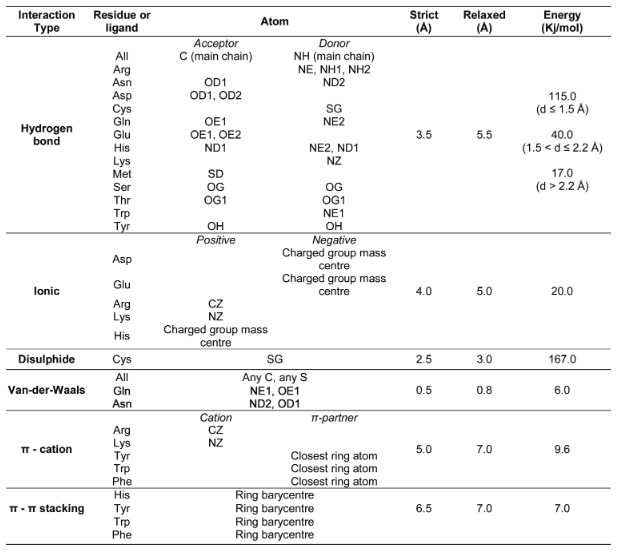

In [2]:
Image('./figs/RING_energy_dist.png')

In [3]:
ThTh_edges = pd.read_csv('../PyMOL_scripts/edges.txt', sep='\t')
ThTh_edges

NodeId1  Interaction     NodeId2  Distance  Angle  Energy Atom1  \
0      0:3001:_:MG   IAC:LIG_MC  0:21:_:LEU     5.220 -999.9     0.0    MG   
1      0:3001:_:MG   IAC:LIG_SC  0:22:_:GLY     3.071 -999.9     0.0    MG   
2      0:3001:_:MG   IAC:LIG_SC  0:23:_:VAL     1.977 -999.9     0.0    MG   
3      0:3001:_:MG   IAC:LIG_MC  0:24:_:LYS     6.141 -999.9     0.0    MG   
4      0:3001:_:MG   IAC:LIG_SC  0:26:_:TYR     4.765 -999.9     0.0    MG   
...            ...          ...         ...       ...    ...     ...   ...   
60217   z:2489:_:G  IAC:LIG_LIG  z:2492:_:U     6.029 -999.9     0.0    N1   
60218   z:2490:_:G  IAC:LIG_LIG  z:2493:_:U     5.722 -999.9     0.0    N2   
60219   z:2494:_:G  IAC:LIG_LIG  z:2497:_:A     6.912 -999.9     0.0   O3'   
60220   z:2495:_:G  IAC:LIG_LIG  z:2498:_:C     6.637 -999.9     0.0    O6   
60221   z:2497:_:A  IAC:LIG_LIG  z:2500:_:U     6.726 -999.9     0.0    C2   

      Atom2 Donor Positive Cation Orientation  
0         O   NaN      NaN    NaN         NaN  
1       HA2   NaN      NaN    NaN         NaN  
2         H   NaN      NaN    NaN         NaN  
3         N   NaN      NaN    NaN         NaN  
4       HE1   NaN      NaN    NaN         NaN  
...     ...   ...      ...    ...         ...  
60217    O4   NaN      NaN    NaN         NaN  
60218    O4   NaN      NaN    NaN         NaN  
60219    N6   NaN      NaN    NaN         NaN  
60220    N4   NaN      NaN    NaN         NaN  
60221    O4   NaN      NaN    NaN         NaN  

[60222 rows x 12 columns]

In [5]:
ThTh_nodes = pd.read_csv('../PyMOL_scripts/nodes_modified_xyz.txt')
name_chains = pd.read_csv('../PyMOL_scripts/1VY4_chain_names.txt', names=['Object', 'Chain'])
ThTh_nodes = pd.merge(ThTh_nodes, name_chains, on='Chain')
ThTh_nodes

NodeId Chain  Position Residue Dssp  Degree  Bfactor_CA    Rapdf  \
0        b:7:_:VAL     b         7     VAL            2       80.50   47.300   
1        b:8:_:LYS     b         8     LYS            1       83.06   -0.528   
2        b:9:_:GLU     b         9     GLU            1       85.55  -46.135   
3       b:10:_:LEU     b        10     LEU    G       3       82.20    3.183   
4       b:11:_:LEU     b        11     LEU    H       1       87.16  -17.470   
...            ...   ...       ...     ...  ...     ...         ...      ...   
10048  M:3027:_:MG     M      3027      MG  NaN      11     -999.90 -999.900   
10049  M:3755:_:MG     M      3755      MG  NaN      10     -999.90 -999.900   
10050  M:3781:_:MG     M      3781      MG  NaN       4     -999.90 -999.900   
10051  M:3157:_:MG     M      3157      MG  NaN       7     -999.90 -999.900   
10052  M:3339:_:MG     M      3339      MG  NaN       7     -999.90 -999.900   

           Tap          x           y           z  Object  
0       -0.000  72.663002  100.995003   17.046000    uS02  
1       -0.905  71.061996   97.872002   15.654000    uS02  
2       -0.087  67.556000   98.230003   14.167000    uS02  
3       -1.270  65.420998   96.823997   11.395000    uS02  
4        0.850  66.606003   97.560997    7.816000    uS02  
...        ...        ...         ...         ...     ...  
10048 -999.900  54.858002  -43.683998 -100.181999  Phase6  
10049 -999.900  35.963001 -105.411003  -22.077999  Phase6  
10050 -999.900  19.162001  -93.500000  -45.623001  Phase6  
10051 -999.900  35.837002  -66.227997   47.847000  Phase6  
10052 -999.900  63.508999 -118.066002  -51.466000  Phase6  

[10053 rows x 13 columns]

In [6]:
def plot_nodes(df):    
    
    data = []
    
    for rPro in set(df['Object']):
        
        rPro_df = df[df['Object'] == rPro]
        data.append(
        go.Scatter3d(
            x = rPro_df['x'],
            y = rPro_df['y'],
            z = rPro_df['z'],
            text = 
                rPro_df['Residue']
                +' '+rPro_df['Dssp'],
            mode = 'markers',
            name = rPro
            )
        )

    layout = go.Layout(
        title = 'Thermus thermophilus Nodes (Atoms) Colored by rProtein and rRNA Phase',
        showlegend = True
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [7]:
plot_nodes(ThTh_nodes)

In [89]:
plot_nodes(ThTh_nodes[ThTh_nodes.Object == 'uL04'])

Unofortunately, I only modified the txt files that I use to make the plots, the xml file still does not have an updated x, y, z. However, I still try and use the dataframe as often as possible

In [7]:
G_ThTh = nx.read_graphml('../Ring_output/1VY4_phase_as_chains/1VY4_phase_as_chains_network.xml')

In [8]:
G_ThTh.nodes['n0']

{'Accessibility': 0.517,
 'Bfactor_CA': 80.5,
 'Degree': 2.0,
 'Dssp': ' ',
 'NodeId': 'b:7:_:VAL',
 'Position': 7.0,
 'Rapdf': 47.3,
 'Residue': 'VAL',
 'Tap': -0.0,
 'name': 'b:7:_:VAL',
 'pdbFileName': '1VY4_phase_as_chains.pdb#7.b',
 'x': 72.663,
 'y': 100.995,
 'z': 17.046}

In [11]:
G_ThTh.edges[('n0', 'n205', 0)]

{'Angle': 25.332,
 'Atom1': 'O',
 'Atom2': 'NE',
 'Cation': 'None',
 'Distance': 2.751,
 'Donor': 'b:217:_:ARG',
 'Energy': 17.0,
 'Interaction': 'HBOND:MC_SC',
 'NodeId1': 'b:7:_:VAL',
 'NodeId2': 'b:217:_:ARG',
 'Orientation': 'None',
 'Positive': 'None'}

In [12]:
def print_top_bottom_5(metric):
    top5 = {key: metric[key] for key in sorted(metric, key=metric.get, reverse=True)[:5]}
    bottom5 = {key: metric[key] for key in sorted(metric, key=metric.get, reverse=False)[:5]}
    print('top5:')
    for x in top5:
        print(x, '\t', top5[x])
    print('bottom5:')
    for x in bottom5:
        print(x, '\t', bottom5[x])

In [77]:
def print_centrality(graph):
    degree = nx.degree_centrality(graph)
    #closeness = nx.closeness_centrality(graph) #takes a long time
    #harmonic = nx.harmonic_centrality(graph) #takes a long time
    #betweenness = nx.betweenness_centrality(graph) #takes a long time
    eigenvector = nx.eigenvector_centrality_numpy(graph)
    # pagerank_085 = nx.pagerank_numpy(graph, alpha=0.85) #takes a long time
    # Katz does not work on multigraph
    print('degree:')
    print_top_bottom_5(degree)
    #print('\ncloseness:')
    #print_top_bottom_5(closeness)
    #print('\nharmonic:')
    #print_top_bottom_5(harmonic)
    #print('\nbetweenness:')
    #print_top_bottom_5(betweenness)
    print('\neigenvector:')
    print_top_bottom_5(eigenvector)
    #print('\npagerank alpha=0.85:')
    #print_top_bottom_5(pagerank_085)

### Takes a while to run

In [14]:
print_centrality(G_ThTh)

degree:
top5:
n6558 	 0.005069486932960406
n7611 	 0.004719867144480377
n7610 	 0.004457652303120356
n7609 	 0.00437024735600035
n6537 	 0.004282842408880343
bottom5:
n6907 	 0.0
n6913 	 0.0
n6915 	 0.0
n6920 	 0.0
n6922 	 0.0

eigenvector:
top5:
n6910 	 0.121438660154
n6550 	 0.116683548163
n7043 	 0.116568325064
n4662 	 0.116377991925
n6909 	 0.114366906191
bottom5:
n4308 	 -2.71328504392e-18
n589 	 -2.70273538311e-18
n410 	 -2.43396064641e-18
n1339 	 -2.34868579592e-18
n4316 	 -2.23803882511e-18


In [15]:
def plot_nodes_partitions(df):  
    
    data = []
    
    for partition_count in range(df['partition'].max()):
        
        partition_df = df[df['partition'] == partition_count]
        data.append(
        go.Scatter3d(
            x = partition_df['x'],
            y = partition_df['y'],
            z = partition_df['z'],
            text = 
                partition_df['Residue']
                +' '+partition_df['Dssp']
                +' '+partition_df['Chain']
                +' '+partition_df['Object'],
            mode = 'markers',
            name = 'partition'+str(partition_count)
            )
        )
        
    layout = go.Layout(
        title = 'Coloring ThTh rProteins and rRNA Phases by Community',
        showlegend = True
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [16]:
def plot_louvain(res, G, make_plot=True):
    partition = community.best_partition(G, resolution=res, weight='Energy')
    partition_df = pd.DataFrame.from_dict(partition, orient='index').reset_index()
    partition_df.rename(columns={0:'partition'}, inplace=True)
    ThTh_partition = ThTh_nodes.join(partition_df)
    ThTh_partition = ThTh_partition.drop(['index'], axis=1)
    print('Resolution:', res)
    print('Number of partitions:',len(set(partition.values())))
    print('Modularity:', community.modularity(partition, G))
    if make_plot == True:
        plot_nodes_partitions(ThTh_partition)
#        ThTh_partition = ThTh_partition[~ThTh_partition.partition.isnull()]
#        ThTh_partition.partition = ThTh_partition.partition.astype(int)
#        plot_nodes_partitions(ThTh_partition)
    return(partition, ThTh_partition)

In [71]:
louvain5, lv5_df = plot_louvain(5, G_ThTh, make_plot=True)

Resolution: 5
Number of partitions: 194
Modularity: 0.7754173146033427


In [108]:
lv5_df

NodeId Chain  Position Residue Dssp  Degree  Bfactor_CA    Rapdf  \
0        b:7:_:VAL     b         7     VAL            2       80.50   47.300   
1        b:8:_:LYS     b         8     LYS            1       83.06   -0.528   
2        b:9:_:GLU     b         9     GLU            1       85.55  -46.135   
3       b:10:_:LEU     b        10     LEU    G       3       82.20    3.183   
4       b:11:_:LEU     b        11     LEU    H       1       87.16  -17.470   
...            ...   ...       ...     ...  ...     ...         ...      ...   
11098  M:3027:_:MG     M      3027      MG  NaN      11     -999.90 -999.900   
11099  M:3755:_:MG     M      3755      MG  NaN      10     -999.90 -999.900   
11100  M:3781:_:MG     M      3781      MG  NaN       4     -999.90 -999.900   
11101  M:3157:_:MG     M      3157      MG  NaN       7     -999.90 -999.900   
11102  M:3339:_:MG     M      3339      MG  NaN       7     -999.90 -999.900   

           Tap  Accessibility          x           y           z  Object  \
0       -0.000          0.517  72.663002  100.995003   17.046000    uS02   
1       -0.905          0.322  71.061996   97.872002   15.654000    uS02   
2       -0.087          0.283  67.556000   98.230003   14.167000    uS02   
3       -1.270          0.597  65.420998   96.823997   11.395000    uS02   
4        0.850          0.741  66.606003   97.560997    7.816000    uS02   
...        ...            ...        ...         ...         ...     ...   
11098 -999.900       -999.900  54.858002  -43.683998 -100.181999  Phase6   
11099 -999.900       -999.900  35.963001 -105.411003  -22.077999  Phase6   
11100 -999.900       -999.900  19.162001  -93.500000  -45.623001  Phase6   
11101 -999.900       -999.900  35.837002  -66.227997   47.847000  Phase6   
11102 -999.900       -999.900  63.508999 -118.066002  -51.466000  Phase6   

       partition  
0              0  
1              0  
2              0  
3              0  
4              1  
...          ...  
11098         33  
11099         33  
11100         17  
11101         17  
11102         17  

[11103 rows x 15 columns]

In [83]:
G_ThTh['n5555']

AdjacencyView({'n5553': {0: {'Distance': 2.995, 'Interaction': 'HBOND:MC_MC', 'Angle': 16.341, 'Orientation': 'None', 'Positive': 'None', 'Energy': 17.0, 'Atom1': 'O', 'Atom2': 'N', 'Cation': 'None', 'NodeId2': 'W:68:_:ARG', 'NodeId1': 'W:65:_:LEU', 'Donor': 'W:68:_:ARG'}}, 'n5597': {0: {'Distance': 2.811, 'Interaction': 'HBOND:MC_MC', 'Angle': 9.672, 'Orientation': 'None', 'Positive': 'None', 'Energy': 17.0, 'Atom1': 'O', 'Atom2': 'N', 'Cation': 'None', 'NodeId2': 'W:110:_:LYS', 'NodeId1': 'W:68:_:ARG', 'Donor': 'W:110:_:LYS'}}, 'n5598': {0: {'Distance': 3.17, 'Interaction': 'HBOND:SC_SC', 'Angle': 34.16, 'Orientation': 'None', 'Positive': 'None', 'Energy': 17.0, 'Atom1': 'NH1', 'Atom2': 'ND1', 'Cation': 'None', 'NodeId2': 'W:111:_:HIS', 'NodeId1': 'W:68:_:ARG', 'Donor': 'W:68:_:ARG'}, 1: {'Distance': 3.868, 'Interaction': 'VDW:SC_SC', 'Angle': -999.9, 'Orientation': 'None', 'Positive': 'None', 'Energy': 6.0, 'Atom1': 'CD', 'Atom2': 'CE1', 'Cation': 'None', 'NodeId2': 'W:111:_:HIS', '

In [86]:
nx.get_node_attributes(G_ThTh, 'n0')

{}

In [84]:
louvain5

{'n0': 0,
 'n1': 0,
 'n2': 0,
 'n3': 0,
 'n4': 1,
 'n5': 0,
 'n6': 0,
 'n7': 1,
 'n8': 0,
 'n9': 0,
 'n10': 0,
 'n11': 0,
 'n12': 0,
 'n13': 0,
 'n14': 2,
 'n15': 2,
 'n16': 2,
 'n17': 2,
 'n18': 2,
 'n19': 2,
 'n20': 2,
 'n21': 2,
 'n22': 0,
 'n23': 2,
 'n24': 2,
 'n25': 0,
 'n26': 0,
 'n27': 0,
 'n28': 0,
 'n29': 0,
 'n30': 0,
 'n31': 2,
 'n32': 0,
 'n33': 0,
 'n34': 0,
 'n35': 0,
 'n36': 3,
 'n37': 0,
 'n38': 0,
 'n39': 0,
 'n40': 3,
 'n41': 0,
 'n42': 0,
 'n43': 0,
 'n44': 0,
 'n45': 0,
 'n46': 0,
 'n47': 0,
 'n48': 0,
 'n49': 0,
 'n50': 0,
 'n51': 0,
 'n52': 0,
 'n53': 0,
 'n54': 0,
 'n55': 0,
 'n56': 0,
 'n57': 0,
 'n58': 0,
 'n59': 0,
 'n60': 0,
 'n61': 0,
 'n62': 0,
 'n63': 0,
 'n64': 0,
 'n65': 0,
 'n66': 0,
 'n67': 0,
 'n68': 0,
 'n69': 0,
 'n70': 0,
 'n71': 0,
 'n72': 0,
 'n73': 0,
 'n74': 0,
 'n75': 0,
 'n76': 0,
 'n77': 0,
 'n78': 0,
 'n79': 0,
 'n80': 0,
 'n81': 0,
 'n82': 0,
 'n83': 0,
 'n84': 0,
 'n85': 0,
 'n86': 0,
 'n87': 0,
 'n88': 0,
 'n89': 0,
 'n90': 0,
 'n91': 0

In [75]:
nx.set_node_attributes(G_ThTh, 'lv5_community', louvain5)

TypeError: unhashable type: 'dict'

In [18]:
louvain6, lv6_df = plot_louvain(6, G_ThTh, False)

Resolution: 6
Number of partitions: 194
Modularity: 0.7759185585362102


In [19]:
normalized_mutual_info_score(list(louvain5.values()), list(louvain6.values()))

0.98884494472938012

In [20]:
resolution = np.linspace(1, 20, num=39, endpoint=True, retstep=False, dtype=None)
resolution

array([  1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,   4.5,   5. ,
         5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,   9. ,   9.5,
        10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,  13.5,  14. ,
        14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,  18. ,  18.5,
        19. ,  19.5,  20. ])

In [21]:
def make_prtn_mod_res_df(resolution_list, G):
    modularity_list = []
    partition_list = []
    
    for res in resolution:
        partition = community.best_partition(G, resolution=res, weight='Energy')
        num_partitions = len(set(partition.values()))
        modularity = community.modularity(partition, G)
        modularity_list.append(modularity)
        partition_list.append(num_partitions)
    
    df = pd.DataFrame(
        {'Resolution':resolution_list,
         'Num_Partitions':partition_list,
         'Modularity':modularity_list})
    
    return(df)

### This next cell takes a crazy long time to run, graph below may be an old version

In [22]:
prtn_mod_res_df = make_prtn_mod_res_df(resolution, G_ThTh)

# Create traces
trace0 = go.Scatter(
    x = prtn_mod_res_df['Resolution'],
    y = prtn_mod_res_df['Num_Partitions'],
    mode = 'lines',
    name = 'Partitions'
)
trace1 = go.Scatter(
    x = prtn_mod_res_df['Resolution'],
    y = prtn_mod_res_df['Modularity'],
    mode = 'lines',
    name = 'Modularity',
    yaxis='y2'
)


layout = go.Layout(
    title='Modularity and Parition Number vs. Louvain Resoution',
    xaxis=dict(
        title='Louvain Resolution'
    ),
    yaxis=dict(
        title='Number of Partitions'
    ),
    yaxis2=dict(
        title='Modularity',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)

data = [trace0, trace1]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [124]:
def plot_nodes_partitions(df):  
    
    data = []
    
    for partition_count in range(df['partition'].max()):
        
        partition_df = df[df['partition'] == partition_count]
        partition_df.Position = partition_df.Position.astype(str)
        data.append(
            go.Scatter3d(
                x = partition_df['x'],
                y = partition_df['y'],
                z = partition_df['z'],
                text = 
                    partition_df['Residue']
                    +' '+partition_df['Position']
                    +' '+partition_df['Dssp']
                    +' '+partition_df['Chain']
                    +' '+partition_df['Object'],
                mode = 'markers',
                name = 'partition'+str(partition_count)
            )
        )
        
    layout = go.Layout(
        title = 'Coloring ThTh rProteins and rRNA Phases by Community',
        showlegend = True
    )

    data.append(
    go.Scatter3d(
        x = df['x'],
        y = df['y'],
        z = df['z'],
        mode = 'lines',
        hoverinfo='none'
        )
    )
    
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [125]:
plot_nodes_partitions(lv5_df[lv5_df.Object == 'uS04'])

/home/nick/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



### Output makes no sense, all nodes are communities

In [23]:
ig_G = ig.Graph.Read_GraphML('../Ring_output/1VY4/1VY4_LSU_rRNA+rProtein_network.xml')

In [24]:
def walktrap_output(stps):
    walktrap = ig.Graph.community_walktrap(ig_G, weights='Energy', steps=stps)
    print('Steps:', stps)
    print('Optimal count:', walktrap.optimal_count)
    print('Modularity:', ig_G.modularity(membership=walktrap.as_clustering()))
    return([e for l in walktrap.merges for e in l])

In [25]:
walktrap2 = walktrap_output(2)

Steps: 2
Optimal count: 5711
Modularity: 0.07320135301685493


In [26]:
walktrap4 = walktrap_output(4)

Steps: 4
Optimal count: 5711
Modularity: 0.07320135301685493


In [27]:
walktrap6 = walktrap_output(6)

Steps: 6
Optimal count: 5711
Modularity: 0.07320135301685493


In [28]:
walktrap8 = walktrap_output(8)

Steps: 8
Optimal count: 5711
Modularity: 0.07320135301685493


In [29]:
walktrap10 = walktrap_output(10)

Steps: 10
Optimal count: 5711
Modularity: 0.07320135301685493


In [30]:
normalized_mutual_info_score(walktrap2, walktrap4)

1.0

In [31]:
walktrap10 = walktrap_output(100)

Steps: 100
Optimal count: 5711
Modularity: 0.07320135301685493


In [32]:
walktrap = ig.Graph.community_walktrap(ig_G, weights='Energy', steps=4)

In [33]:
walktrap

In [34]:
print(walktrap)

Dendrogram, 7374 elements, 7359 merges


In [36]:
ig.

'Dendrogram, 7374 elements, 7359 merges'

In [37]:
def plot_girvan_newman(res, G, make_plot=True):
    partition = girvan_newman(G)
    partition_df = pd.DataFrame.from_dict(partition, orient='index').reset_index()
    partition_df.rename(columns={0:'partition'}, inplace=True)
    ThTh_partition = ThTh_nodes.join(partition_df)
    ThTh_partition = ThTh_partition.drop(['index'], axis=1)
    print('Resolution:', res)
    print('Number of partitions:',len(set(partition.values())))
    print('Modularity:', community.modularity(partition, G))
    if make_plot == True:
        plot_nodes_partitions(ThTh_partition)
#        ThTh_partition = ThTh_partition[~ThTh_partition.partition.isnull()]
#        ThTh_partition.partition = ThTh_partition.partition.astype(int)
#        plot_nodes_partitions(ThTh_partition)
    return(partition, ThTh_partition)

In [39]:
partition = nx.girvan_newman(G_ThTh)

AttributeError: module 'networkx' has no attribute 'girvan_newman'